In [50]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.autograd import Variable

**0. Necessary Setup**

In [38]:
# Using cuda GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**1. Getting the required data**

In [30]:
# Loading the Data
X = []
y = []
label_decoder = ['Rock','Paper','Scissor']
for dirname, _, filenames in os.walk('drive/MyDrive/Colab-Data/rps_data/rock'):
    for filename in filenames:
      X.append(cv2.cvtColor(cv2.imread(os.path.join(dirname, filename)), cv2.COLOR_BGR2RGB))
      y.append(0)
for dirname, _, filenames in os.walk('drive/MyDrive/Colab-Data/rps_data/paper'):
    for filename in filenames:
      X.append(cv2.cvtColor(cv2.imread(os.path.join(dirname, filename)), cv2.COLOR_BGR2RGB))
      y.append(1)
for dirname, _, filenames in os.walk('drive/MyDrive/Colab-Data/rps_data/scissors'):
    for filename in filenames:
      X.append(cv2.cvtColor(cv2.imread(os.path.join(dirname, filename)), cv2.COLOR_BGR2RGB))
      y.append(2)
X = np.stack(X)
y = np.stack(y)
print("X Shape: ", X.shape)
print("y Shape: ", y.shape)

X Shape:  (2188, 200, 300, 3)
y Shape:  (2188,)


In [31]:
# Shuffling the data
combined_data = list(zip(X, y))
np.random.shuffle(combined_data)
shuffled_images, shuffled_labels = zip(*combined_data)
X = np.array(shuffled_images)
y = np.array(shuffled_labels)
X.shape

(2188, 200, 300, 3)

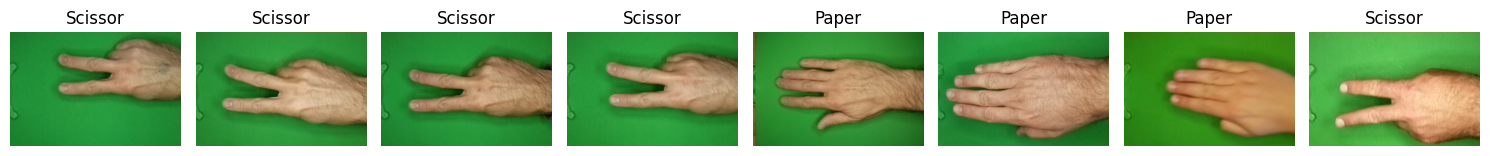

In [32]:
# Printing sample of the data
fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(X[i])
    axes[i].set_title(label_decoder[y[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [33]:
class ImagesDataset(Dataset):

    def __init__(self, images, labels , transform = None):

        self.transform = transform

        self.labels = np.asarray(labels)
        self.images = np.asarray(images).reshape(-1, 200, 300, 3).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

train_set = ImagesDataset(X_train, y_train,transform=transforms.Compose([transforms.ToTensor()]))
test_set = ImagesDataset(X_test, y_test,transform=transforms.Compose([transforms.ToTensor()]))

print("Train Set Size: ", len(train_set))
print("Test Set Size: ", len(test_set))

train_loader = DataLoader(train_set, batch_size=40, shuffle=True)  # shuffle=True for training
test_loader = DataLoader(test_set, batch_size=40, shuffle=False)  # shuffle=False for testing

Train Set Size:  1750
Test Set Size:  438


Text(0.5, 1.0, 'Scissor')

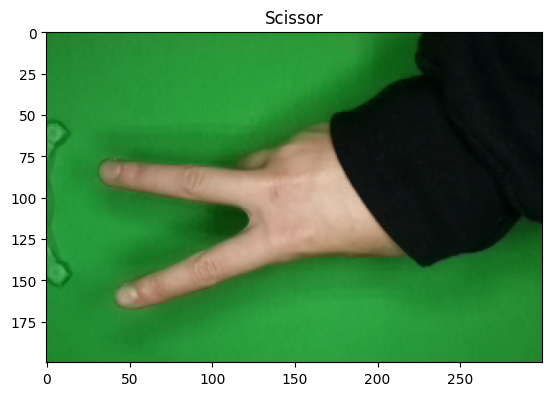

In [99]:
image, label = next(iter(train_set))
image = image.permute(1, 2, 0)
image = image/255
plt.imshow(image.squeeze())
plt.title(label_decoder[label])

In [151]:
class RPSCNN(nn.Module):

  def __init__(self):
    super(RPSCNN,self).__init__()

    self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )


    self.fc1 = nn.Linear(in_features=128*23*36, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)
    self.fc4 = nn.Linear(in_features=10, out_features=3)


  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = out.view(out.size(0), -1)
      out = self.fc1(out)
      out = self.drop(out)
      out = self.fc2(out)
      out = self.fc3(out)
      out = self.fc4(out)

      return out

In [152]:
model = RPSCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

RPSCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=105984, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_fe

**2. Training the model**

In [153]:
num_of_epochs = 30
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_of_epochs):
  train_loss = 0.0
  test_loss = 0.0
  train_accuracy = 0.0
  test_accuracy = 0.0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    # Forward Pass
    output = model(images)
    # Finding Loss
    loss = error(output,labels)
    # Optimizing Loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    _, predicted = torch.max(output, 1)
    train_accuracy += (predicted == labels).sum().item()
  for images, labels in test_loader:
    with torch.no_grad():
      images, labels = images.to(device), labels.to(device)
      # Forward Pass
      output = model(images)
      # Finding Loss
      loss = error(output,labels)
      test_loss += loss.item()
      _, predicted = torch.max(output, 1)
      test_accuracy += (predicted == labels).sum().item()
  train_loss = train_loss/len(train_loader)
  test_loss = test_loss/len(test_loader)
  train_accuracy = train_accuracy/len(train_set)
  test_accuracy = test_accuracy/len(test_set)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  train_accuracy_history.append(train_accuracy)
  test_accuracy_history.append(test_accuracy)
  print(f"Epoch: {epoch}, Training Loss: {train_loss:.2f}, Training Accuracy: {train_accuracy*100:.2f}%")


Epoch: 0, Training Loss: 56.60, Training Accuracy: 42.80%
Epoch: 1, Training Loss: 0.84, Training Accuracy: 78.06%
Epoch: 2, Training Loss: 0.37, Training Accuracy: 88.23%
Epoch: 3, Training Loss: 0.31, Training Accuracy: 90.34%
Epoch: 4, Training Loss: 0.24, Training Accuracy: 91.89%
Epoch: 5, Training Loss: 0.21, Training Accuracy: 93.89%
Epoch: 6, Training Loss: 0.20, Training Accuracy: 93.94%
Epoch: 7, Training Loss: 0.18, Training Accuracy: 93.94%
Epoch: 8, Training Loss: 0.21, Training Accuracy: 93.54%
Epoch: 9, Training Loss: 0.16, Training Accuracy: 94.69%
Epoch: 10, Training Loss: 0.16, Training Accuracy: 94.91%
Epoch: 11, Training Loss: 0.13, Training Accuracy: 95.49%
Epoch: 12, Training Loss: 0.11, Training Accuracy: 96.17%
Epoch: 13, Training Loss: 0.21, Training Accuracy: 93.09%
Epoch: 14, Training Loss: 0.14, Training Accuracy: 95.83%
Epoch: 15, Training Loss: 0.10, Training Accuracy: 96.97%
Epoch: 16, Training Loss: 0.09, Training Accuracy: 96.86%
Epoch: 17, Training Los

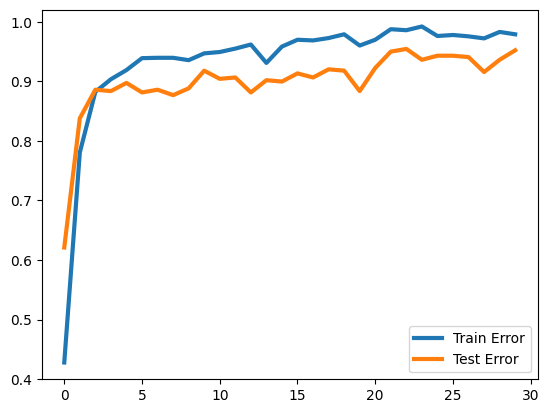

In [155]:
fig = plt.figure()
plt.plot(range(30),train_accuracy_history,"-",linewidth=3,label="Train Error")
plt.plot(range(30),test_accuracy_history,"-",linewidth=3,label="Test Error")
plt.legend()
plt.show()

In [156]:
model.eval()  # Set the model to evaluation mode
all_predicted = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        all_predicted.extend(predicted.cpu().numpy())

# Calculate accuracy using all_predicted and test_set.labels
accuracy = (np.array(all_predicted) == test_set.labels).mean()
print(f"Model Accuracy: {accuracy*100:.2f}%")

Model Accuracy: 95.66%


In [166]:
torch.save(model.state_dict(),'drive/MyDrive/Colab-Data/rsp.pt')